# Основная часть

## Загрузка и первичный анализ

In [37]:
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

In [38]:
best_models = {}
search_summaries = {}
results = []

In [39]:
FIGURES_DIR = Path("artifacts/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [40]:
# вспомогательные функции для составления таблицы сравнений метрик моделей
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

In [41]:
# функции рисования графиков

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.savefig(FIGURES_DIR / "confusion_matrix.jpg")
    plt.show()
    

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig(FIGURES_DIR / "roc.jpg")
    plt.show()
    

In [42]:
data = pd.read_csv('S06-hw-dataset-02.csv')
data.head(10)

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0
5,6,2.977878,3.088654,-0.197899,2.108979,0.039480,0.798094,-1.119793,2.408403,-0.555855,...,-0.157844,0.503093,0.220765,1.489865,4.116737,-0.815933,-5.120649,9.197635,0.880213,1
6,7,2.473418,8.520288,1.307130,4.086821,2.795773,-1.760687,-2.670722,3.629828,-1.817547,...,-0.125201,-1.085034,-1.229092,-0.301936,-3.410467,-0.014363,1.161173,21.074235,21.831822,0
7,8,-1.571984,-0.573208,0.308809,-1.100997,-2.161888,1.224171,0.517167,-4.743501,1.997271,...,0.682501,-3.216268,-2.007971,-0.681398,-5.161191,1.250632,5.016772,0.901073,0.374336,0
8,9,-2.595672,1.650248,0.017120,-4.217647,-0.280851,0.644834,-0.944358,-0.124713,3.571426,...,3.541427,-1.353347,1.776881,0.428259,-6.197406,0.071479,3.546397,-4.283503,0.304540,1
9,10,0.025874,-2.873845,0.438832,-5.353178,1.517070,-0.555454,-1.160253,-1.635842,-0.239880,...,-0.392255,1.057885,0.424084,1.335843,-3.849633,-3.615579,6.410028,-0.074358,12.575392,0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [44]:
data.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [45]:
data.shape

(18000, 39)

In [46]:
# проверка на пропуски
data.isnull().sum()

id         0
f01        0
f02        0
f03        0
f04        0
f05        0
f06        0
f07        0
f08        0
f09        0
f10        0
f11        0
f12        0
f13        0
f14        0
f15        0
f16        0
f17        0
f18        0
f19        0
f20        0
f21        0
f22        0
f23        0
f24        0
f25        0
f26        0
f27        0
f28        0
f29        0
f30        0
f31        0
f32        0
f33        0
f34        0
f35        0
x_int_1    0
x_int_2    0
target     0
dtype: int64

In [47]:
# распределение таргета
data.target.value_counts()

target
0    13273
1     4727
Name: count, dtype: int64

In [48]:
# разделение признаков и таргета в отдельные таблицы
X = data.drop(columns=["id", "target"])
y = data.target

In [49]:
feature_names = list(X.columns)

In [50]:
X.head(2)

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f28,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2
0,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,1.121683,...,0.293322,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167
1,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,-0.298809,...,1.924549,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826


In [51]:
y.head(2)

0    1
1    0
Name: target, dtype: int64

In [52]:
# функция сохранения в json

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

## Train/Test-сплит и воспроизводимость

In [53]:
# отделяем тестовую выборку (20% данных)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,          # важно для классификации: сохраняем долю классов. если не делать стратификацию, то модель учится на данных, не описывающих реальность (модель будет работать неправильно с большой вероятностью)
    random_state=RANDOM_STATE, # фиксированный seed важен для воспризводимости результата, ведь при разном seed каждый раз будет разный результат, что не годится для сравнения моделей
)
X_train.shape, X_test.shape

((14400, 37), (3600, 37))

## Baselines

In [54]:
# CV = кросс-валидация на train: нужна для подбора гиперпараметров без доступа к тесту.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [55]:
baseline_1 = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
baseline_1.fit(X_train, y_train)

baseline_2_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("baseline_2_pipeline", LogisticRegression(
            max_iter=4000,
            random_state=RANDOM_STATE
        ))
    ]
)
baseline_2_grid = {
    "baseline_2_pipeline__C": [0.1, 1.0, 10.0],
    "baseline_2_pipeline__penalty": ["l2"],
    "baseline_2_pipeline__solver": ["lbfgs"],
}
baseline_2_search = GridSearchCV(
    baseline_2_pipeline, baseline_2_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

In [56]:
baseline_2_search.fit(X_train, y_train)
baseline_2 = baseline_2_search.best_estimator_

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [57]:
# считаем метрики на test
results.append(evaluate_on_test(baseline_1, X_test, y_test, "Dummy"))
results.append(evaluate_on_test(baseline_2, X_test, y_test, "LogisticRegression"))

In [58]:
# сохранение лучших моделей
best_models["Dummy"] = baseline_1
best_models["LogisticRegression"] = baseline_2

In [59]:
results

[{'accuracy': 0.6152777777777778,
  'f1': 0.2660307366189719,
  'roc_auc': 0.5026724060622366,
  'model': 'Dummy'},
 {'accuracy': 0.8119444444444445,
  'f1': 0.5606748864373783,
  'roc_auc': 0.7976922846979344,
  'model': 'LogisticRegression'}]

самым лучшим бейзлайном является логистическая регрессия (0.81 vs 0.79 у dummy классификатора)

## Модели

In [60]:
# Единая функция для подбора гиперпараметров через GridSearchCV.

def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [61]:
# модель дерева решений

dt = DecisionTreeClassifier(random_state=RANDOM_STATE,
                            max_depth=10,
                            min_samples_leaf=2)

dt_grid = {
    "max_depth": [None, 3, 5, 8, 10, 20],
    "min_samples_leaf": [1, 5, 10, 20, 30, 40],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 40},
 'best_cv_roc_auc': 0.8368161187183715}

In [62]:
# bagging (ансамбль деревьев)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9250491580899667}

In [63]:
# Gradient Boosting (градиентный бустинг)

hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, 5, None],
    "max_leaf_nodes": [5, 15, 31, 63],
}

hgb_search = run_search("Boosting", hgb, hgb_grid)
search_summaries["Boosting"]

{'best_params': {'learning_rate': 0.05,
  'max_depth': None,
  'max_leaf_nodes': 63},
 'best_cv_roc_auc': 0.9316701338860615}

In [64]:
# stcking (ансамбль разных моделей)

# в качестве базовых моделей возьмём уже готовые "сильные" модели.
estimators = [
    ("lr", best_models["LogisticRegression"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["Boosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5, # для обучения логистической регрессии используются oof пресказания
    n_jobs=-1,
    passthrough=False
)

stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

## Метрики качества

In [65]:
result_df = pd.DataFrame(results)
result_sorted = result_df.copy()
result_sorted["roc_auc_sort"] = result_df["roc_auc"].fillna(-1.0)
result_sorted = result_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

In [66]:
result_sorted # вывод результатов с сортировкой по убыванию roc_auc и accuracy

,accuracy,f1,roc_auc,model
5,0.913889,0.827969,0.933036,Stacking
4,0.905278,0.802548,0.931244,Boosting
3,0.890556,0.755583,0.926152,RandomForest
2,0.836389,0.651685,0.841482,DecisionTree
1,0.811944,0.560675,0.797692,LogisticRegression
0,0.615278,0.266031,0.502672,Dummy


In [67]:
best_row = result_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

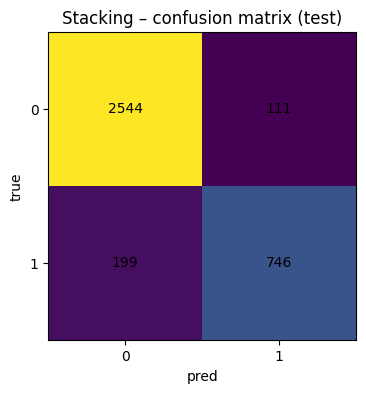

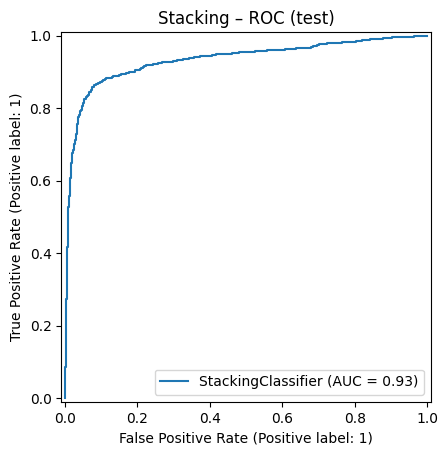

In [68]:
y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")

ROC-кривая модели Stacking показывает высокое качество разделения классов — AUC = 0.93, что близко к идеальному значению 1.0. Модель эффективно находит положительные примеры, не допуская большого числа ложных срабатываний.

## Интерпритация модели

Лучшей моделью оказаслся stacking. Вычислим permutation importance для 15 признаков в рамках лучшей модели

In [69]:
perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)

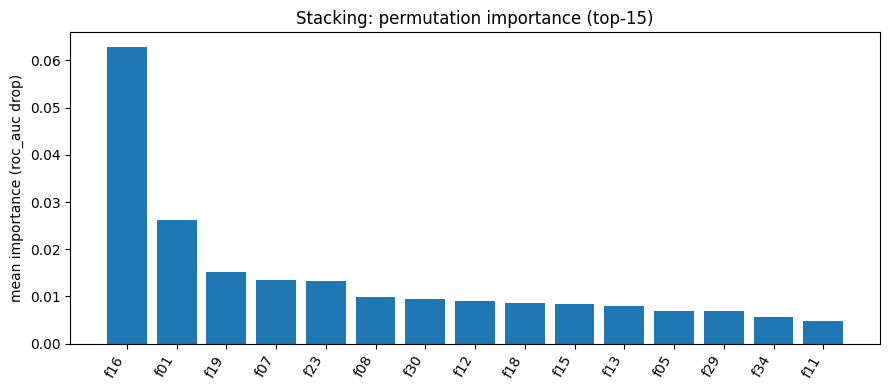

In [70]:
imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance (roc_auc drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

f16 признак влияет больше всех по результатам проведения permutation importance

# Сохранение артефактов эксперемента

In [71]:
sorted_results = {}
for model in result_sorted.to_dict(orient="records"):
    sorted_results[model["model"]] = {"accuracy" : model["accuracy"],
                                      "f1" : model["f1"],
                                      "roc_auc" : model["roc_auc"]}


save_json(sorted_results, ARTIFACTS_DIR / "metrics_test.json")
save_json(search_summaries, ARTIFACTS_DIR / "search_summaries.json")


In [72]:
# Сохранение лучшей модели и метаданных.

model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")